# Predicción del band gap usando métodos de aprendizaje máquina.
El objetivo de esta notebook es predecir el ban gap de materiales bidimensionales utilizando técnicas de aprendizaje máquina.
## Flujo de trabajo.
El flujo de trabajo se divide en 6 niveles que se retroalimentan de acuerdo a los resultados preeliminares, este flujo esta basado en la metodología de la ciencia de datos
### 1. Minado de datos.
Tomar los resultados de una base de datos (JARVIS 2D DFT) y definir las variables objetivo. Qué pueden ser la energía de formación, la banda prohibida y la energía de exfoliación. 
### 2. Generación de descriptores.
Obtener el espacio de características usando como descriptores la información estructural y la composición química. Generar el espacio de características para la base de datos.
### 3. Análisis exploratorio y estandarización.
Vamos a realizar un análisis estadístico exploratorio para conocer nuestra base de datos, esto permitirá visualizar nuestra base de datos y hacer una mejor evaluación de los modelos que vamos a utilizar. Además de una estandarización de los datos con respecto al valor medio o la varianza. 
### 4. Técnicas de divisón y plegamiento.
En esta sección vamos a dividir la base de datos en conjuntos de entrenamiento y de evaluación. 

### 5. Entrenamiento de modelos AM.
Una correcta defición de los datos que se usarán para entrenar el modelo y otra para evaluarlo.
### 6. Extracción de características.


### 1. Recuperación y filtrado de datos.

In [1]:
#Cargar la base de datos de interés 
#jarvis_dft_2d
from matminer.datasets import load_dataset
df = load_dataset('jarvis_dft_2d')

In [2]:
# Extraemos la base de datos completa en formato .json
import pandas as pd
def extract(file_path):
    # Leemos el archivo json en formato de dataframe
    return pd.read_json(file_path)

# Llamamos a la función en el formato deseado
jarvis_2d_dft = extract("jdft_2d-7-7-2018.json")

In [3]:
# Extraemos aquellas columnas de interes del dataframe jarvis_2d_dft
lp = jarvis_2d_dft['final_str']
H = jarvis_2d_dft['form_enp']
phi = jarvis_2d_dft['phi']
fin_energy = jarvis_2d_dft['fin_en']

In [4]:
# Listas donde vamos a guardar los datos de interés 
a = []
volumen = []
phi_ = []
n_electron = []
Ef = []
avg_max = []
fin_energy_ = []

#Extracción de datos del data frame
for i, dic in enumerate(lp):
    a.append(dic['lattice']['a'])
    volumen.append(dic['lattice']['volume'])
    
for dic in phi:
    phi_.append(dic['phi'])
    n_electron.append(dic['nelect'])
    Ef.append(dic['Ef'])
    avg_max.append(dic['avg_max'])

# Convertimos las listas en dataframes
a = pd.DataFrame(a, columns=['a'])
volumen = pd.DataFrame(volumen, columns=['volumen'])
phi = pd.DataFrame(phi_, columns=['phi'])
n_electron =  pd.DataFrame(n_electron, columns=['n_electron'])
Ef = pd.DataFrame(Ef, columns=['Ef'])
avg_max = pd.DataFrame(avg_max, columns=['avg_max'])


In [5]:
df = pd.concat([df,H, a, volumen, phi, n_electron, Ef, avg_max, fin_energy], axis=1)

In [196]:
df = df[(df['gap opt'] >= 0.5) & (df['gap opt'] <= 3.0)]

In [7]:
# Quitando columnas innecesarias, para el resto utilizarlos como descriptores y el identificador MP-ID.
# Descriptores: structure y composition
df = df.drop(['structure initial','gap tbmbj','epsilon_x tbmbj',
              'epsilon_y tbmbj','epsilon_z tbmbj','jid', 'e_form', 'mpid', 
              'epsilon_x opt', 'epsilon_y opt', 'epsilon_z opt', 'exfoliation_en', ], axis=1)
df

,structure,gap opt,composition,form_enp,a,volumen,phi,n_electron,Ef,avg_max,fin_en
1,"[[1.85068084 4.37698238 6.9301577 ] As, [0. ...",0.7467,(As),0.16,3.701362,442.549182,4.496743,20,-2.632596,1.864147,-11.702720
5,"[[ 3.70891373 -2.28956375 0.30684745] Sb, [0....",2.2826,"(Sb, As, O)",-1.306,4.485823,471.138618,5.374376,56,-2.356434,3.017943,-42.769943
6,"[[0.9242204 1.67995032 9.23318039] Mo, [2.772...",1.8234,"(Mo, O)",-2.04,3.696882,410.219760,8.034892,60,-5.286669,2.748223,-51.510766
7,[[ 2.57809927e+00 -2.09669113e-05 3.45302620e...,0.5289,"(Te, Cr, Ge)",-0.04,6.898647,966.276252,5.044703,88,-1.961521,3.083182,-22.565136
8,"[[0. 0. 3.74714516] Zr, [1.829...",1.3309,"(Zr, Br, N)",-1.769,3.658791,351.745934,5.815096,48,-2.251504,3.563592,-35.593087
...,...,...,...,...,...,...,...,...,...,...,...
623,"[[2.25072699 3.96567228 1.8545467 ] Ca, [-0.00...",2.2170,"(Ca, Pb, I)",-1.103,4.512732,843.300471,5.815918,52,-3.343289,2.472629,-4.656104
629,"[[1.50454899 3.54979796 3.70676971] Nb, [9.401...",0.6524,"(Nb, I)",-0.45,7.652973,1314.355779,4.638687,89,-2.040338,2.59835,-23.478550
633,"[[2.74646086 0.06822876 1.46596737] Se, [6.324...",1.3010,"(Se, Cl, Pd)",-0.062,9.071567,2145.835639,5.19863,144,-3.119466,2.079164,-35.943619
634,"[[6.79056646 2.04327631 3.37729406] I, [2.0440...",1.8036,"(I, Hg)",-0.101,8.834578,2088.004996,5.736219,104,-4.010233,1.725985,12.138384


Al final de este paso hemos minado una base de datos que fue limpiada, se seleccionó un rango de valores de la banda prohibida ($E_g$), se eliminaron aquellas intancias que de las que no hubiera informaci[on disponible en MP y se quitaron las columnas por ahora innecesarias: de la que podemos extraer tres posibles variables objetivo: $E_g$, energía de formación ($E_f$) y la energía de exfolicación ($E_{exf}$). Los descriptores que vamos a utilizar son $structure$ que es una descripción de la estructura cristalina del material (Posiciomes atómicas) y $composition$ que es la composición atómica del material. Finalmente se extrajeron los parámetros de red para cada ID que si se encontraba en la base de datos. 

### 2. Generación de descriptores.
Para generar las descripciones vamos a usar la libreria de Matminer y Pymatgen que nos proveen de diferentes fuciones para obtener información entendible para los modelos dada la estructura cristalina, la composición química y propiedades electrónicas. Estos vendrían a ser nuestros descriptores, con los cuales podemos obtener para cada instancia un valor numérico, categórico o una mezcla que nos permite codificar esa información física en información para la máquina. Est[an basados en diferentes modelos de represdentación de la información cristalina en datos para informar modelos de ML. 

In [8]:
from matminer.featurizers.composition.alloy import YangSolidSolution

#Caracaterísticas basadas en aleación 
yang = YangSolidSolution()
df = yang.featurize_dataframe(df,'composition', ignore_errors=True)


YangSolidSolution:   0%|          | 0/269 [00:00<?, ?it/s]

In [9]:
from matminer.featurizers.composition.composite import ElementProperty
properties = ['Number', 'MendeleevNumber', 'AtomicWeight', 'MeltingT',
              'Column', 'Row', 'CovalentRadius', 'Electronegativity',
              'SpaceGroupNumber']

element_pro = ElementProperty('magpie', properties, ['mean','avg_dev'])

df = element_pro.featurize_dataframe(df,'composition', ignore_errors=True)


ElementProperty:   0%|          | 0/269 [00:00<?, ?it/s]

In [10]:
properties2 = ['atom_num', 'atom_mass',  "atom_radius", 'molar_vol',
               'heat_fusion', 'melting_point', 'boiling_point', 'heat_cap',
               'first_ioniz', "electric_pol", 'GGAU_Etot']

element_pro = ElementProperty('deml', properties, ['mean','avg_dev'])

df = element_pro.featurize_dataframe(df,'composition', ignore_errors=True)

ElementProperty:   0%|          | 0/269 [00:00<?, ?it/s]

In [11]:
from matminer.featurizers.composition.element import TMetalFraction
tm_frac = TMetalFraction()
df = tm_frac.featurize_dataframe(df, 'composition', ignore_errors=True)

TMetalFraction:   0%|          | 0/269 [00:00<?, ?it/s]

In [13]:
#Librerias generadoras de características
from matminer.featurizers.composition.element import BandCenter, Stoichiometry
from matminer.featurizers.composition.orbital import AtomicOrbitals, ValenceOrbital

from matminer.featurizers.structure.order import StructuralComplexity, DensityFeatures
from matminer.featurizers.structure.symmetry import GlobalSymmetryFeatures

# Creamos la clases para generar características basados en composición

# Características basadas en composición elemental y estequimetria
st = Stoichiometry() # Calcular normas de atributos estequiométricos
bc = BandCenter() # Estimación de la posición absoluta del centro de banda (electronegatividad)

# Características basadas en datos de orbitales
ao = AtomicOrbitals() # Determinar características  basadas ern HOMO-LUMO
vo = ValenceOrbital() # Atributos de valencia orbital en capas


# Creamos la clases para generar características basados en estructura

#Características basadas empaquetamiento y ordenamiento
sc = StructuralComplexity() # Información de Entropía de Shannon de una estructura
den_fea = DensityFeatures() # Densidades basadas en la estructura

# Características basadas en simetrias
gsf = GlobalSymmetryFeatures()
#Función generadora de características de un dataframe

df1 = st.featurize_dataframe(df,'composition', ignore_errors=True)
df2 = bc.featurize_dataframe(df1,'composition', ignore_errors=True)
df3 = ao.featurize_dataframe(df2,'composition', ignore_errors=True)
df4 = vo.featurize_dataframe(df3,'composition', ignore_errors=True)
df5 = sc.featurize_dataframe(df4, 'structure', ignore_errors=True)
df6 = den_fea.featurize_dataframe(df5, 'structure', ignore_errors=True)
df7 = gsf.featurize_dataframe(df6, 'structure', ignore_errors=True)


Stoichiometry:   0%|          | 0/269 [00:00<?, ?it/s]

BandCenter:   0%|          | 0/269 [00:00<?, ?it/s]

AtomicOrbitals:   0%|          | 0/269 [00:00<?, ?it/s]

ValenceOrbital:   0%|          | 0/269 [00:00<?, ?it/s]

StructuralComplexity:   0%|          | 0/269 [00:00<?, ?it/s]

spglib: Attempt 0 tolerance = 1.000000e-01 failed(line 800, /project/src/spacegroup.c).
spglib: Attempt 0 tolerance = 1.000000e-01 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-01 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 2 tolerance = 9.025000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 3 tolerance = 8.573750e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 4 tolerance = 8.145062e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group w

DensityFeatures:   0%|          | 0/269 [00:00<?, ?it/s]

GlobalSymmetryFeatures:   0%|          | 0/269 [00:00<?, ?it/s]

spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 2 tolerance = 9.025000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 3 tolerance = 8.573750e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 4 tolerance = 8.145062e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 5 tolerance = 7.737809e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 4

In [14]:
# Eliminamos aquellas columnas que no me funcionan para trabajar coomo una caracteristica
df = df7.drop(['structure', 'composition','HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element'], axis=1)

In [15]:
df = df.dropna(axis=1) # Eliminamos columnas con valores nulos

In [16]:
# Convertimos columnas con valores de caracter a numéricos para las columnas que se pueden codificar
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

df = MultiColumnLabelEncoder(columns = ['is_centrosymmetric', 'crystal_system']).fit_transform(df)

In [47]:
df = df.drop(['a','volumen','phi','Ef','avg_max','fin_en', '0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm'], axis=1)

In [64]:
df = df.drop(['is_centrosymmetric','spacegroup_num', 'crystal_system','crystal_system_int', 'is_centrosymmetric', 
              'n_symmetry_ops' ],axis=1)

In [109]:
df = df.drop(['MagpieData mean Row','avg s valence electrons','structural complexity per atom',
              'frac p valence electrons'],axis=1)

In [155]:
df = df.drop(['MagpieData avg_dev Row','MagpieData mean Electronegativity',
             'MagpieData mean SpaceGroupNumber','transition metal fraction', 
             'frac f valence electrons','structural complexity per cell',
             'avg f valence electrons'], axis=1)

In [199]:
df = df.drop(['avg d valence electrons'], axis=1)

In [179]:
df = df.drop(['MagpieData mean MendeleevNumber','gap_AO',
              'frac s valence electrons','avg p valence electrons'], axis=1)

In [228]:
df = df.drop(['MagpieData mean Number', 'MagpieData avg_dev Number',
              'MagpieData avg_dev MendeleevNumber', 'MagpieData mean AtomicWeight',
              'MagpieData avg_dev AtomicWeight','MagpieData mean Column', 
              'MagpieData mean CovalentRadius',
              'MagpieData avg_dev CovalentRadius',
              'MagpieData avg_dev Electronegativity','frac d valence electrons'
             ], axis=1)

In [301]:
df.columns

Index(['gap opt', 'form_enp', 'n_electron', 'Yang omega',
       'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT',
       'MagpieData avg_dev Column', 'MagpieData avg_dev SpaceGroupNumber',
       'HOMO_energy', 'LUMO_energy'],
      dtype='object')

In [302]:
df = df.drop(['LUMO_energy','MagpieData avg_dev MeltingT'],axis=1)

#### Referencias de las funciones de generación de descriptores

In [303]:
# Basadas en composición
print('** Basadas en composición elemental y estequiometria **')
print(st.citations()) # vo, 
print(bc.citations())
print('** Basadas en orbitales atómicos **')
print(ao.citations())
print('** Basadas en enlaces **')
print('** Basadas en empaquetamiento y ordenamiento **')
print(sc.citations())
print(den_fea.citations()) # La imprime vacia
print('** Basadas en simetrias **')
print(gsf.citations()) # La imprime vacia 

** Basadas en composición elemental y estequiometria **
['@article{ward_agrawal_choudary_wolverton_2016, title={A general-purpose machine learning framework for predicting properties of inorganic materials}, volume={2}, DOI={10.1038/npjcompumats.2017.28}, number={1}, journal={npj Computational Materials}, author={Ward, Logan and Agrawal, Ankit and Choudhary, Alok and Wolverton, Christopher}, year={2016}}']
['@article{Butler1978, author = {Butler, M A and Ginley, D S}, doi = {10.1149/1.2131419}, isbn = {0013-4651}, issn = {00134651}, journal = {Journal of The Electrochemical Society}, month = {feb}, number = {2}, pages = {228--232}, title = {{Prediction of Flatband Potentials at Semiconductor-Electrolyte Interfaces from Atomic Electronegativities}}, url = {http://jes.ecsdl.org/content/125/2/228}, volume = {125}, year = {1978} } ']
** Basadas en orbitales atómicos **
['@article{PhysRevA.55.191,title = {Local-density-functional calculations of the energy of atoms},author = {Kotochigova, S

Hasta ahora hemos formado la base de datos que se va a usar en el proceso de aprendizaje de los modelos. El onjeto $df$ contiene la variable objetivo y las características del fenómeno. Se ha considerado transformar la información de las columnas $HOMO$ $character$, $LUMO$ $character$, $crystal$ $system$ e $is$ $centrosymmetric$ utilizando label encoder de sklearn. 

### 3. Análisis exploratorio y estandarización.
Realizaremos un análisis previo a la aplicación de los modelos de aprendizaje ya que se ha mostrado que algunos son sensibles a una estandarización de los datos con respecto a la media o la varianza. Esto nos permitirá hacer una detección de algún dato anómalo y un mejor rendimiento en las métricas de comparación. 

In [304]:
df.describe()

,gap opt,n_electron,Yang omega,MagpieData mean MeltingT,MagpieData avg_dev Column,MagpieData avg_dev SpaceGroupNumber,HOMO_energy
count,264.000000,264.000000,2.640000e+02,264.000000,264.000000,264.000000,264.000000
mean,1.629961,55.083333,4.178526e+06,673.661740,2.897892,57.437470,-0.256862
std,0.631770,31.840630,2.487183e+06,369.341738,2.075831,24.524241,0.051168
min,0.508800,8.000000,0.000000e+00,138.554286,0.000000,0.000000,-0.415606
25%,1.168350,32.000000,2.412955e+06,427.460000,0.960000,39.111111,-0.276481
50%,1.577050,48.000000,3.925751e+06,623.470833,2.666667,59.751479,-0.261676
75%,2.027100,68.000000,5.456157e+06,828.409167,4.500000,73.003951,-0.226594
max,2.998000,196.000000,1.409998e+07,3823.000000,7.111111,112.500000,-0.118123


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 1 to 635
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gap opt                              264 non-null    float64
 1   form_enp                             264 non-null    object 
 2   n_electron                           264 non-null    int64  
 3   Yang omega                           264 non-null    float64
 4   MagpieData mean MeltingT             264 non-null    float64
 5   MagpieData avg_dev Column            264 non-null    float64
 6   MagpieData avg_dev SpaceGroupNumber  264 non-null    float64
 7   HOMO_energy                          264 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 18.6+ KB


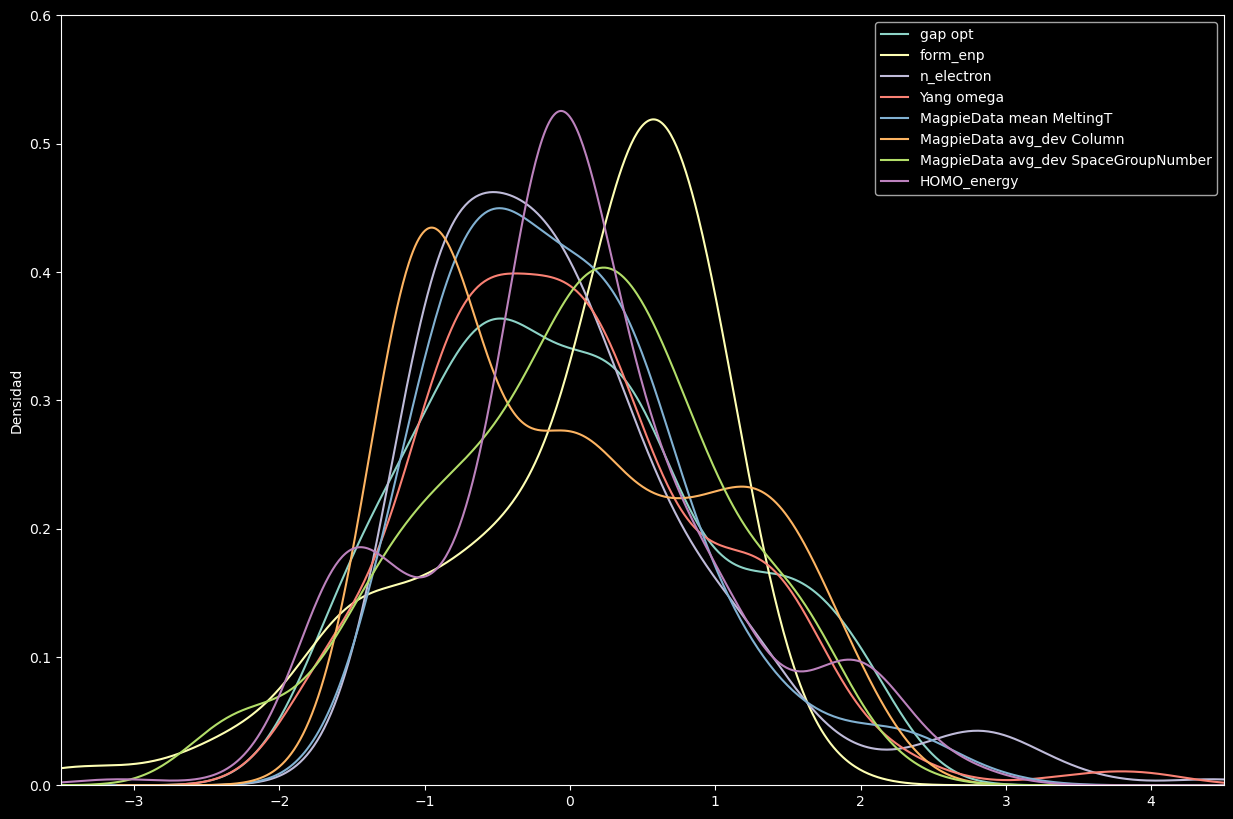

In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Suponiendo que df_standardized es tu dataframe con características estandarizadas
# Asegúrate de que df_standardized solo contenga las características que deseas trazar
# Si hay demasiadas características, selecciona solo un subconjunto de ellas

# Estandarizar los datos
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)
df_standardized = pd.DataFrame(df_standardized, columns=df.columns)

# Establecer estilo oscuro
plt.style.use('dark_background') 

# Trazar densidades de cada variable de característica
# Aquí se establece layout=(5, 7) para trazar 35 características en 5 filas y 7 columnas
df_standardized.plot(kind='density', subplots=False, layout=(5, 7), figsize=(15, 10), sharex=False, xlim=(-4, 5), ylim=(0, 1.2))
plt.xlim(-3.5,4.5)
plt.ylim(0,0.6)
plt.ylabel('Densidad')
plt.savefig('density_features.png', dpi=300, format='png', bbox_inches='tight')

plt.show()


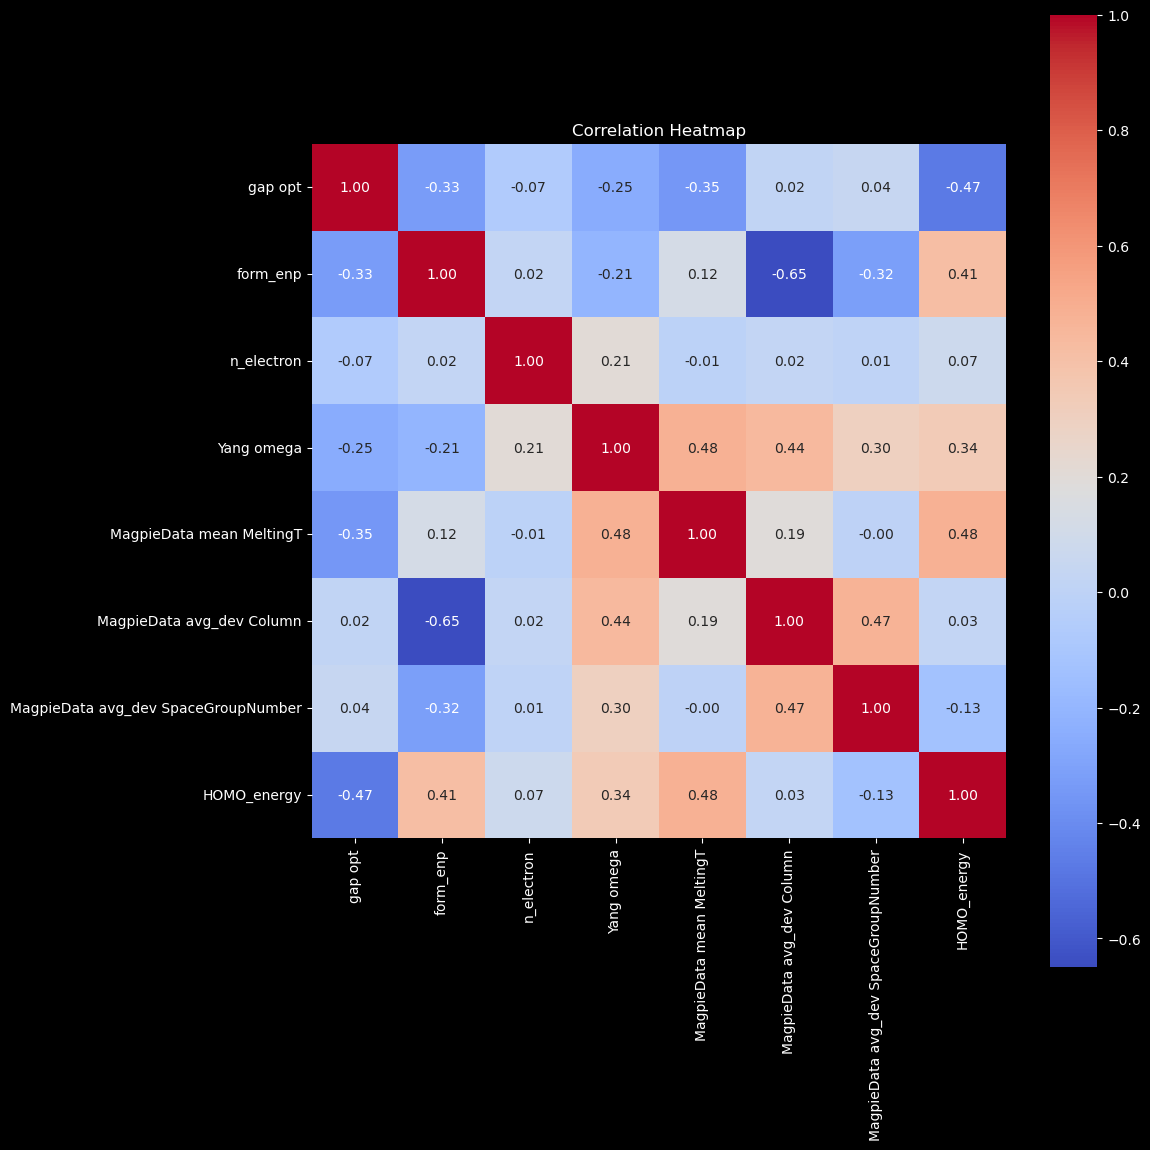

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de correlación
corr_matrix = df_standardized.corr()

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 12))

# Título del gráfico
plt.title('Correlation Heatmap')

# Crear el mapa de calor
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True) #annot_kws={"size": 18}

# Ajustar el diseño de la figura
plt.tight_layout()
plt.savefig('corr_map.png', dpi=300, format='png', bbox_inches='tight')
# Mostrar el gráfico
plt.show()


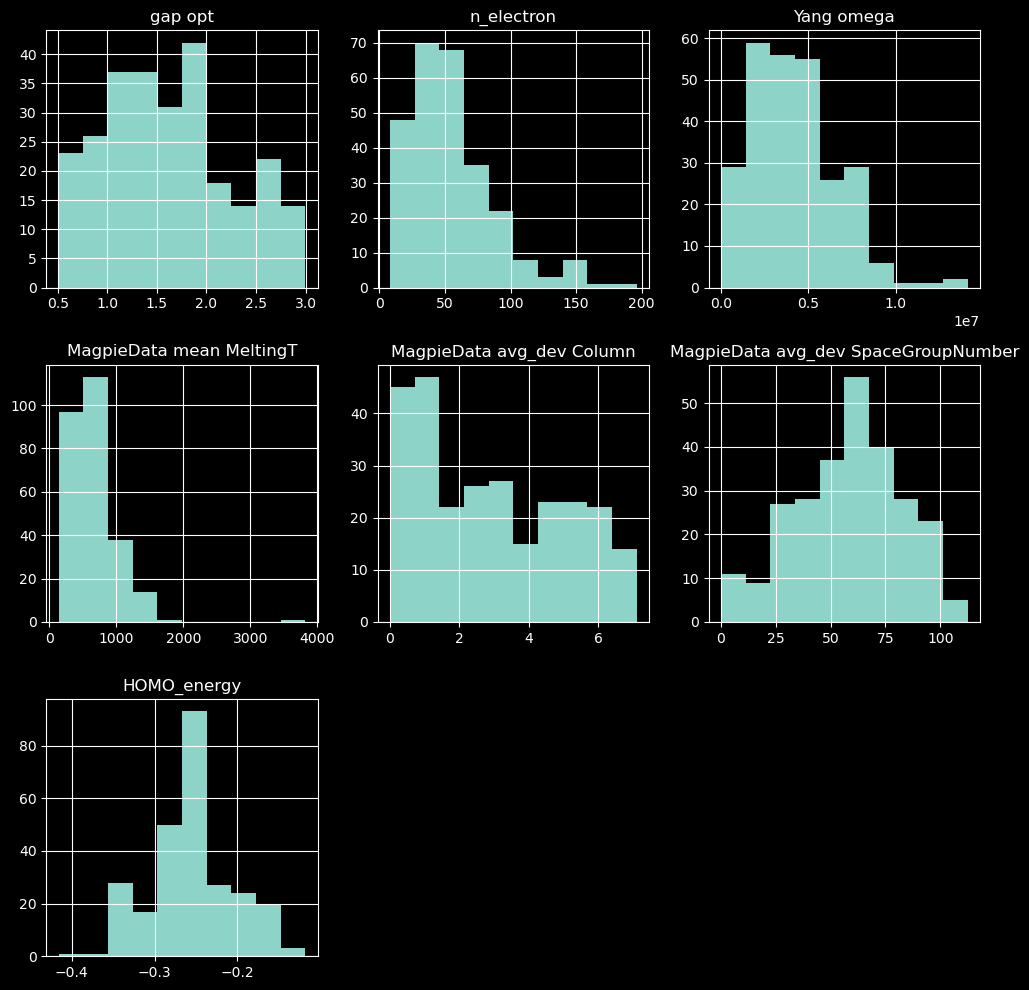

In [341]:
# Plot histograms for each numerical column
df.hist(figsize=(10, 10))
plt.tight_layout()
plt.savefig('bar.plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


### 4. Técnicas de divisón y plegamiento.

In [342]:
# Definimos las variables objetivo y características
y = df['gap opt'] # Variable objetivo
x = df.drop(['gap opt'], axis=1) # Características

In [311]:
# Definimos el 30% para la evaluación y el 70% para el modelo.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [312]:
# Validación cruzada
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

kfold = KFold(n_splits=30, shuffle=True, random_state=None) # 100 pliegues

In [313]:
# Estandarización de datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Escalador: Resta la media y divide por la varianza cada dato. 

# Para ser usados en division simple
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Para ser usados en validación cruzada
x_scaled = scaler.fit_transform(x)

### 5. Primeras pruebas de entrenamiento de modelos AM.

In [314]:
# Importammos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt

# Modelos de regresión lineal simple
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Modelos de arboles desición
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Red neuronal
from sklearn.neural_network import MLPRegressor

# Máquinas de soporte vectorial
from sklearn.svm import SVR

# Métrica de rendimiento
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score


#### Modelos de regresión Lineal

** Métricas de rendimiento: Datos escalados y división simple x_train=30% y y_test=70%. **
R² =  0.004593860044442066
RMSE =  0.6052438760069523
** Métricas de rendimento: Validación cruzada con k_fold=10 **
R² media (Validación cruzada:) 0.35664721130595
Desviación estándar: 0.8801211611259471


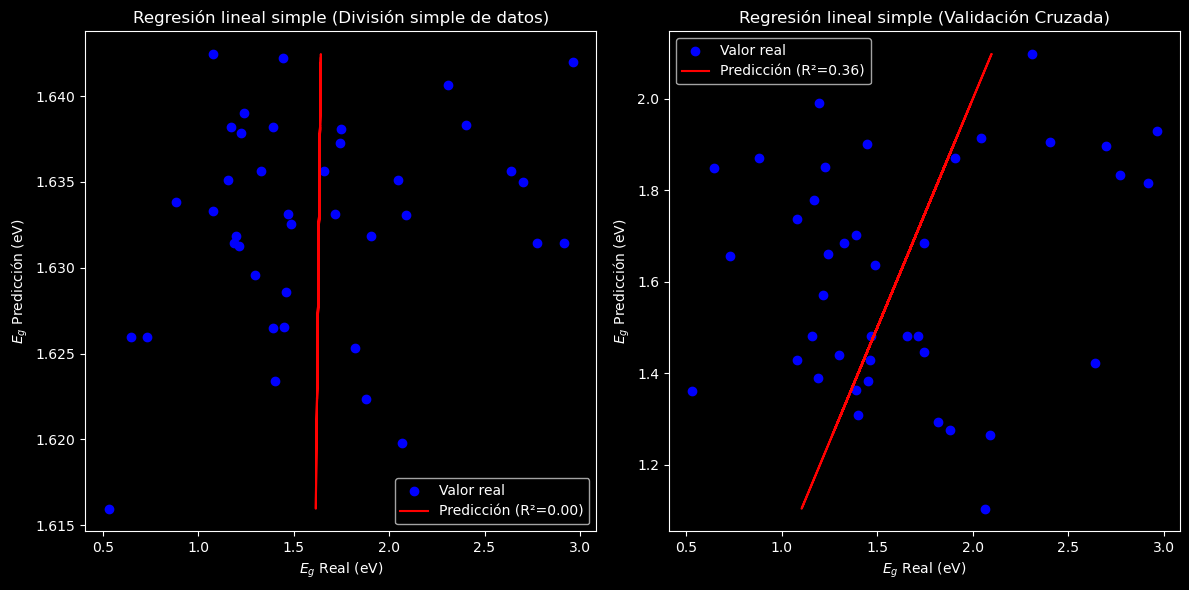

[-7.67243231e-02 -3.07201150e-02 -2.67727415e-02 -8.42061675e-02
 -1.55697315e-01 -8.20616250e-02 -6.91226053e-02 -3.13344747e-02
 -8.47437383e-01 -2.43545530e-01  8.09455697e-04 -1.01521975e-02
 -1.84891132e-03 -1.99884648e-01 -4.90578100e-02 -4.13680807e-01
 -4.21738188e-02 -7.38916779e-02 -1.92176011e-01 -1.65649899e-02
 -1.90444404e-02 -1.10396805e+00 -1.15862202e+00 -3.67132448e-01
 -2.18716492e-01 -5.38486311e-02 -4.81365705e+00 -1.00019472e-01
 -1.96549014e-01 -2.16150293e-02]


In [318]:
# Modelo de regresión lineal simple, la función de perdida es: LossFunction = S(yi - yj)²

# Usando una división simple fit_intercept=True positive=True
linear_reg = LinearRegression(n_jobs=14, positive=True) # Creamos el regresor
linear_reg.fit(x_train_scaled, y_train) # Entrenamos al modelo
y_predict1 = linear_reg.predict(x_test_scaled) # Mostramos nuevos datos al modelo

# Métricas de división simple
r2 = linear_reg.score(x_test_scaled, y_test) # R²  
rmse = mean_squared_error(y_test, y_predict1, squared=False) # Root-Mean-Square-Error

# Usando validación cruzada
cv_results = cross_val_score(linear_reg, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict2 = cross_val_predict(linear_reg, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción

# Métricas de validación cruzada
cv_score = -1*np.mean(cv_results) # El valor medio de cada pliegue que se hizo
cv_desv = np.std(cv_results)   # La desviación estándar

print('** Métricas de rendimiento: Datos escalados y división simple x_train=30% y y_test=70%. **')
print('R² = ', r2)
print('RMSE = ', rmse)

print('** Métricas de rendimento: Validación cruzada con k_fold=10 **')
print('R² media (Validación cruzada:)', cv_score)
print('Desviación estándar:', cv_desv)

# Gráficas
# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Regresión lineal simple (División simple de datos)')
axs[0].scatter(y_test, y_predict1, color='blue', label='Valor real' )
axs[0].plot(y_predict1, y_predict1, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Regresión lineal simple (Validación Cruzada)')
axs[1].scatter(y_test, y_predict2, color='blue',label='Valor real' )
axs[1].plot(y_predict2, y_predict2, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('lineal_simple.png', dpi=300, format='png', bbox_inches='tight')
plt.show()
print(cv_results)

** Modelo Ridge **
-- división simple --
R² =  0.004593857901053489
RMSE =  0.6052438766585821
-- Validación cruzada --
R² media (Validación cruzada:) 0.3699555510985074
Desviación estándar: 0.8298126735316308


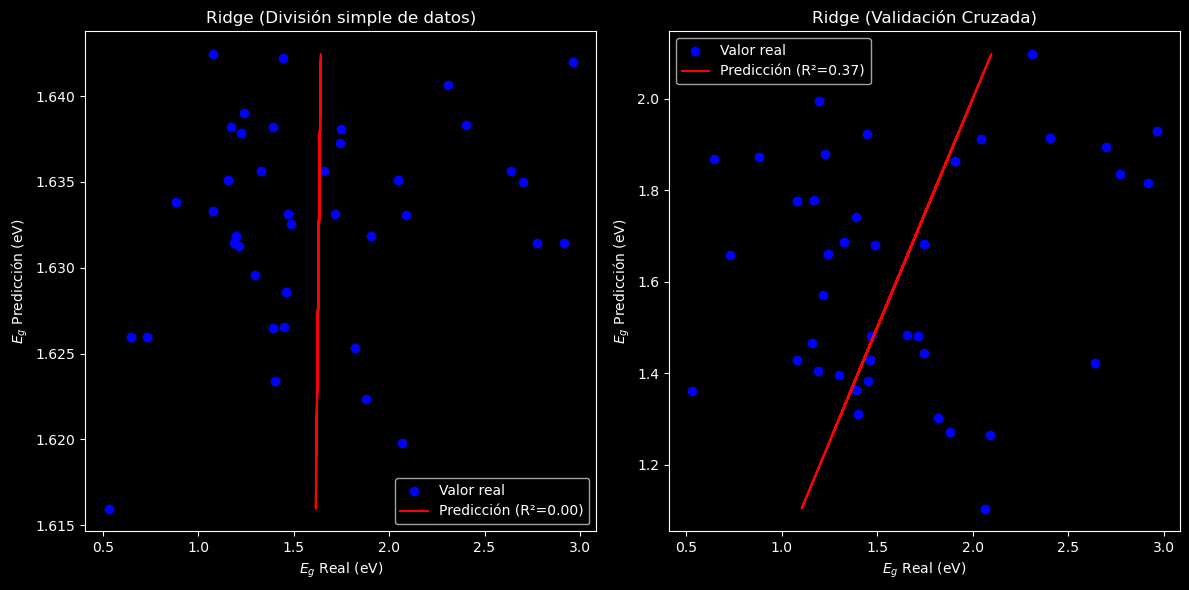

In [325]:
# Modelo Ridge minimiza Lossfunctrion=||y - Xw||^2_2 + alpha * ||w||^2_2 positive=True
ridge = Ridge(alpha = 0.0001, max_iter=10000, solver='auto', positive=True)
# Usando división simple
ridge.fit(x_train_scaled, y_train)
y_predict3 = ridge.predict(x_test_scaled)
# Rendimiento
r2_ridge = ridge.score(x_test_scaled, y_test) # R²  
rmse_ridge = mean_squared_error(y_test, y_predict3, squared=False)

# Usando validación cruzada
cv_results_ridge = cross_val_score(ridge, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict4 = cross_val_predict(ridge, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_ridge = -1*np.mean(cv_results_ridge) # El valor medio de cada pliegue que se hizo R²
cv_desv_ridge = np.std(cv_results_ridge)   # La desviación estándar

print('** Modelo Ridge **')
print('-- división simple --') 
print('R² = ', r2_ridge)
print('RMSE = ', rmse_ridge)

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_ridge)
print('Desviación estándar:', cv_desv_ridge)

# Gráficas
# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Ridge (División simple de datos)')
axs[0].scatter(y_test, y_predict3, color='blue', label='Valor real' )
axs[0].plot(y_predict3, y_predict3, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_ridge)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Ridge (Validación Cruzada)')
axs[1].scatter(y_test, y_predict4, color='blue',label='Valor real' )
axs[1].plot(y_predict4, y_predict4, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_ridge)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('lineal_ridge.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

** Modelo Lasso **
-- división simple --
R² =  0.0038872655276258605
RMSE =  0.6054586557432474
-- Validación cruzada --
R² media (Validación cruzada:) 0.40228586792077553
Desviación estándar: 0.6771955581898346


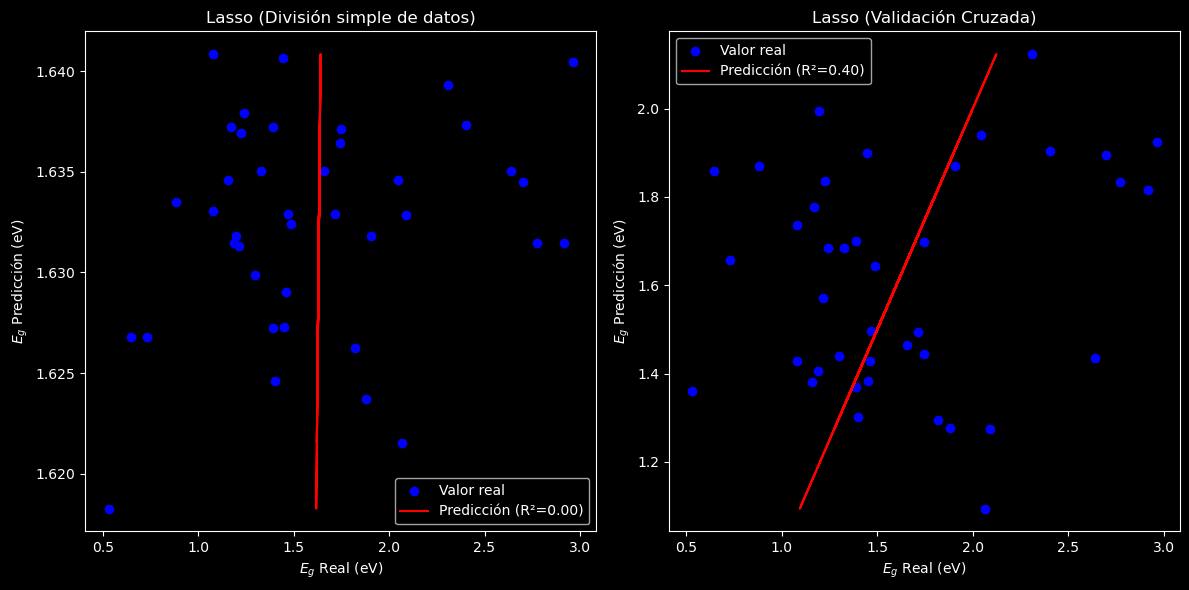

In [335]:
# Modelo Lasso minimiza Lossfunctrion=(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
lasso = Lasso(alpha=0.001, max_iter=200000, selection='random',positive=True)
# Usando división simple
lasso.fit(x_train_scaled, y_train)
y_predict5 = lasso.predict(x_test_scaled)
# Rendimiento
r2_lasso = lasso.score(x_test_scaled, y_test) # R²  
rmse_lasso = mean_squared_error(y_test, y_predict5, squared=False)

# Usando validación cruzada
cv_results_lasso = cross_val_score(lasso, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict6 = cross_val_predict(lasso, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_lasso = -1*np.mean(cv_results_lasso) # El valor medio de cada pliegue que se hizo R²
cv_desv_lasso = np.std(cv_results_lasso)   # La desviación estándar

print('** Modelo Lasso **')
print('-- división simple --') 
print('R² = ', r2_lasso)
print('RMSE = ', rmse_lasso)

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_lasso)
print('Desviación estándar:', cv_desv_lasso)

# Gráficas
# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Lasso (División simple de datos)')
axs[0].scatter(y_test, y_predict5, color='blue', label='Valor real' )
axs[0].plot(y_predict5, y_predict5, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_lasso)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Lasso (Validación Cruzada)')
axs[1].scatter(y_test, y_predict6, color='blue',label='Valor real' )
axs[1].plot(y_predict6, y_predict6, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_lasso)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('lineal_lasso.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

** Modelo Elastic Net **
-- división simple --
R² =  0.004238889666298484
RMSE =  0.6053517839696191
-- Validación cruzada --
R² media (Validación cruzada:) 0.4270398366739233
Desviación estándar: 0.9570983328095042


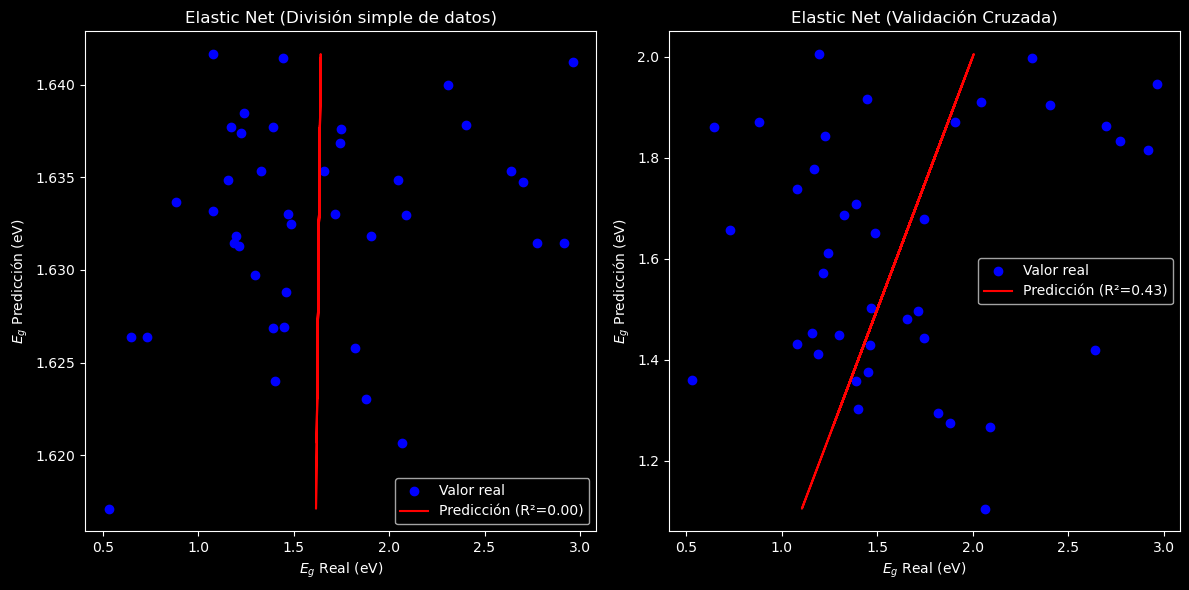

In [336]:
# Modelo Elastic Net minimiza 
# Lossfunctrion=1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
enet = ElasticNet(alpha=0.001, max_iter=50000, selection='random',positive=True) # Crear modelo ElasticNet
# Usando división simple
enet.fit(x_train_scaled, y_train)
y_predict7 = enet.predict(x_test_scaled)
# Rendimiento
r2_enet = enet.score(x_test_scaled, y_test) # R²  
rmse_enet = mean_squared_error(y_test, y_predict7, squared=False)

# Usando validación cruzada
cv_results_enet = cross_val_score(enet, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict8 = cross_val_predict(enet, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_enet = -1*np.mean(cv_results_enet) # El valor medio de cada pliegue que se hizo R²
cv_desv_enet = np.std(cv_results_enet)   # La desviación estándar

print('** Modelo Elastic Net **')
print('-- división simple --') 
print('R² = ', r2_enet)
print('RMSE = ', rmse_enet)

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_enet)
print('Desviación estándar:', cv_desv_enet)

# Gráficas
# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Elastic Net (División simple de datos)')
axs[0].scatter(y_test, y_predict7, color='blue', label='Valor real' )
axs[0].plot(y_predict7, y_predict7, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_enet)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Elastic Net (Validación Cruzada)')
axs[1].scatter(y_test, y_predict8, color='blue',label='Valor real' )
axs[1].plot(y_predict8, y_predict8, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_enet)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('lineal_elastic_net.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

#### Modelo de arboles de desición 

** Modelo Bosque Aleatorio **
-- división simple --
R² =  0.6006660330398714
RMSE =  0.3833525640955273
-- Validación cruzada --
R² media (Validación cruzada:) -0.12110260775659158
Desviación estándar: 0.6725865774470062


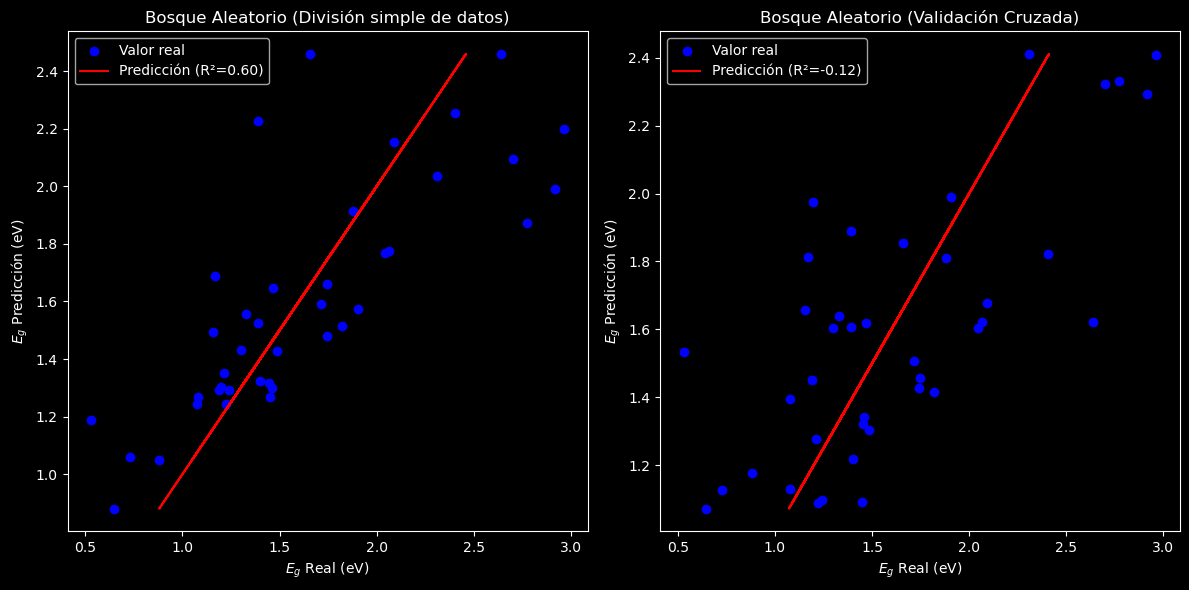

In [476]:
# Crear modelo de Random Forest
random_forest_regre = RandomForestRegressor(n_estimators=1000, criterion='absolute_error', max_depth=30, 
                                            min_samples_split=5, max_features=0.8, min_samples_leaf=3, n_jobs=14)
# Usando división simple
random_forest_regre.fit(x_train_scaled, y_train)
y_predict9 = random_forest_regre.predict(x_test_scaled)
# Rendimiento
r2_forest = random_forest_regre.score(x_test_scaled, y_test) # R²  
rmse_forest = mean_squared_error(y_test, y_predict9, squared=False)

# Usando validación cruzada
cv_results_forest = cross_val_score(random_forest_regre, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict10 = cross_val_predict(random_forest_regre, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_forest = -1*np.mean(cv_results_forest) # El valor medio de cada pliegue que se hizo R²
cv_desv_forest = np.std(cv_results_forest)   # La desviación estándar

print('** Modelo Bosque Aleatorio **')
print('-- división simple --') 
print('R² = ', r2_forest)
print('RMSE = ', rmse_forest)

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_forest)
print('Desviación estándar:', cv_desv_forest)

# Gráficas
# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Bosque Aleatorio (División simple de datos)')
axs[0].scatter(y_test, y_predict9, color='blue', label='Valor real' )
axs[0].plot(y_predict9, y_predict9, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_forest)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Bosque Aleatorio (Validación Cruzada)')
axs[1].scatter(y_test, y_predict10, color='blue',label='Valor real' )
axs[1].plot(y_predict10, y_predict10, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_forest)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('random_forest.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

** Modelo Bosque Aleatorio **
-- división simple --
R² =  0.3841097044436018
RMSE =  0.47608218090998566
-- Validación cruzada --
R² media (Validación cruzada:) -0.0606806619936028
Desviación estándar: 0.5382263925500187


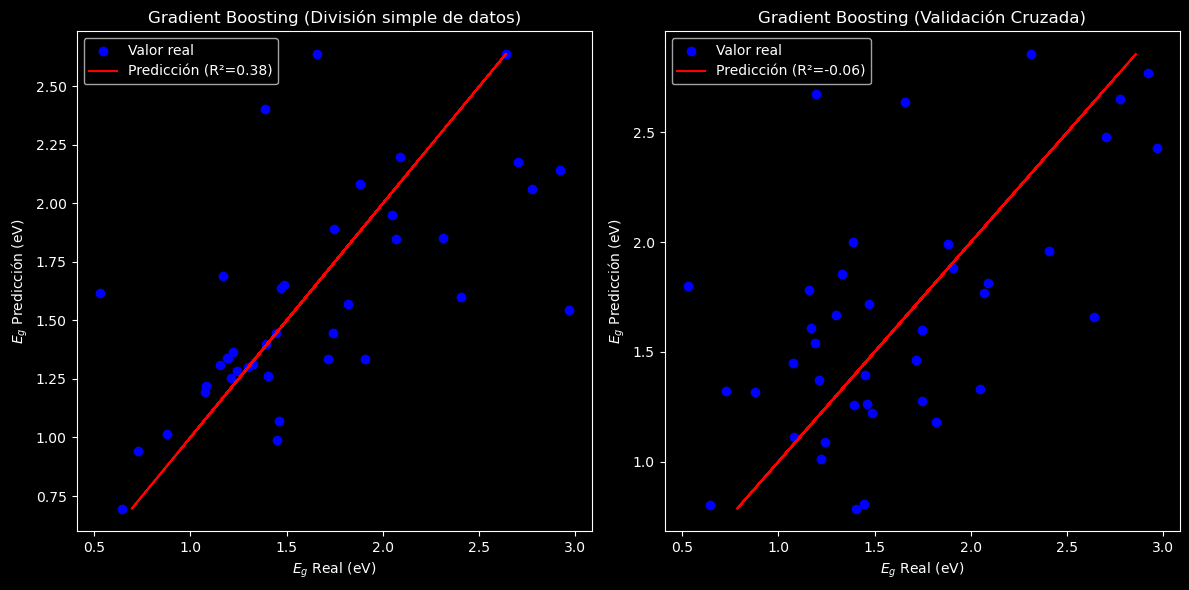

In [477]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=15000, max_depth=40, min_samples_split=5, max_features=0.9,
                                learning_rate=0.01, random_state=50) # Creamos el modelo 
# Usando división simple
gbr.fit(x_train_scaled, y_train)
y_predict11 = gbr.predict(x_test_scaled)
# Rendimiento
r2_boosting = gbr.score(x_test_scaled, y_test) # R²  
rmse_boosting = mean_squared_error(y_test, y_predict11, squared=False)

# Usando validación cruzada
cv_results_boosting = cross_val_score(gbr, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict12 = cross_val_predict(gbr, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_boosting = -1*np.mean(cv_results_boosting) # El valor medio de cada pliegue que se hizo R²
cv_desv_boosting = np.std(cv_results_boosting)   # La desviación estándar

print('** Modelo Bosque Aleatorio **')
print('-- división simple --') 
print('R² = ', r2_boosting)
print('RMSE = ', rmse_boosting)

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_boosting)
print('Desviación estándar:', cv_desv_boosting)

# Gráficas
# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Gradient Boosting (División simple de datos)')
axs[0].scatter(y_test, y_predict11, color='blue', label='Valor real' )
axs[0].plot(y_predict11, y_predict11, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_boosting)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Gradient Boosting (Validación Cruzada)')
axs[1].scatter(y_test, y_predict12, color='blue',label='Valor real' )
axs[1].plot(y_predict12, y_predict12, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_boosting)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('Boosting.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

#### Multilayer perceptron 

** Modelo Red Neuronal multicapa **
-- división simple --
R² =  0.4511312211872286
RMSE =  0.47608218090998566
-- Validación cruzada --
R² media (Validación cruzada:) 0.0030115566420339484
Desviación estándar: 0.38872204882292544


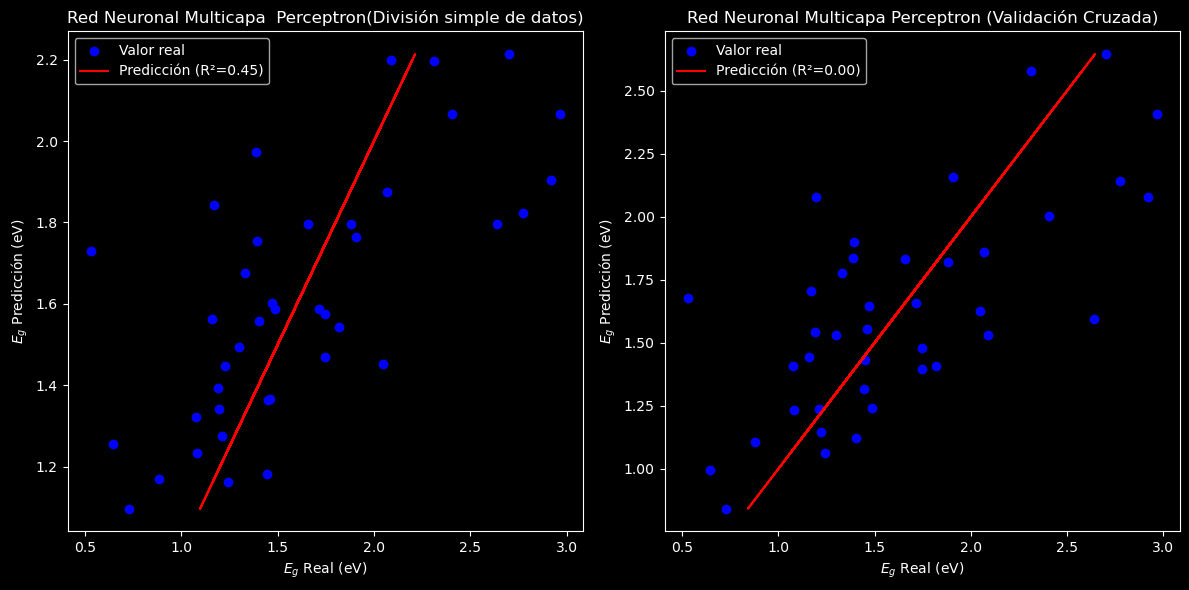

In [356]:
mlp_reg = MLPRegressor(solver='sgd', hidden_layer_sizes=(100,50,50,100), alpha=1e-8, max_iter=15000)

# Usando división simple
mlp_reg.fit(x_train_scaled, y_train)
y_predict13 = mlp_reg.predict(x_test_scaled)
# Rendimiento
r2_neural = mlp_reg.score(x_test_scaled, y_test) # R²  
rmse_neural = mean_squared_error(y_test, y_predict11, squared=False)

# Usando validación cruzada
cv_results_neural = cross_val_score(mlp_reg, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict14 = cross_val_predict(mlp_reg, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_neural = -1*np.mean(cv_results_neural) # El valor medio de cada pliegue que se hizo R²
cv_desv_neural = np.std(cv_results_neural)   # La desviación estándar

print('** Modelo Red Neuronal multicapa **')
print('-- división simple --') 
print('R² = ', r2_neural)
print('RMSE = ', rmse_neural)

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_neural)
print('Desviación estándar:', cv_desv_neural)

# Gráficas

# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Red Neuronal Multicapa  Perceptron(División simple de datos)')
axs[0].scatter(y_test, y_predict13, color='blue', label='Valor real' )
axs[0].plot(y_predict13, y_predict13, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_neural)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Red Neuronal Multicapa Perceptron (Validación Cruzada)')
axs[1].scatter(y_test, y_predict14, color='blue',label='Valor real' )
axs[1].plot(y_predict14, y_predict14, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_neural)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('perceptron.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

#### Máquinas de soporte vectorial

** Modelo Máquina de soporte vectorial **
-- división simple --
R² =  0.4049088467717422
RMSE =  0.46797428907531174
-- Validación cruzada --
R² media (Validación cruzada:) 0.26525092278602863
Desviación estándar: 0.9729239963418289


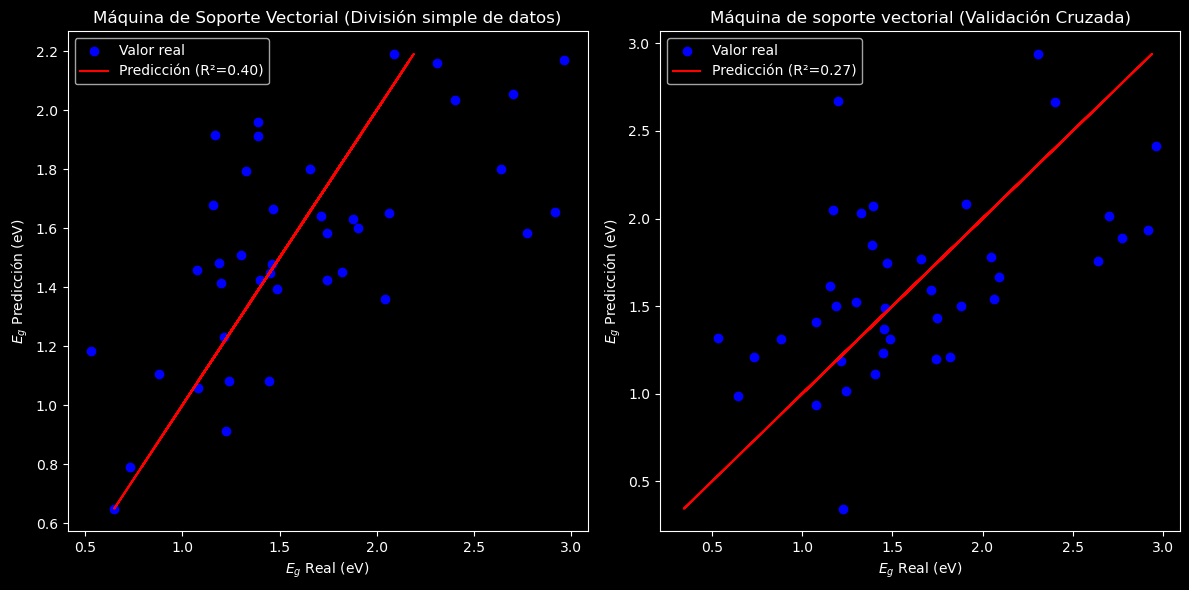

In [473]:
svm = SVR(kernel='linear')
# Usando división simple
svm.fit(x_train_scaled, y_train)
y_predict15 = svm.predict(x_test_scaled)
# Rendimiento
r2_vec = svm.score(x_test_scaled, y_test) # R²  
rmse_vec = mean_squared_error(y_test, y_predict15, squared=False)

# Usando validación cruzada
cv_results_vec = cross_val_score(svm, x_train_scaled, y_train, cv=kfold) # Entrenamiento del modelo con validación cruzada
y_predict16 = cross_val_predict(svm, x_test_scaled, y_test, cv=kfold) # Haciendo la predicción
# Métricas de validación cruzada
cv_score_vec = -1*np.mean(cv_results_vec) # El valor medio de cada pliegue que se hizo R²
cv_desv_vec = np.std(cv_results_vec)   # La desviación estándar

print('** Modelo Máquina de soporte vectorial **')
print('-- división simple --') 
print('R² = ', r2_vec)
print('RMSE = ', rmse_vec )

print('-- Validación cruzada --')
print('R² media (Validación cruzada:)', cv_score_vec)
print('Desviación estándar:', cv_desv_vec)

# Gráficas

# Crear la figura y las subgráficas, 2 filas, 1 columna
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

# Primera gráfica
axs[0].set_title('Máquina de Soporte Vectorial (División simple de datos)')
axs[0].scatter(y_test, y_predict15, color='blue', label='Valor real' )
axs[0].plot(y_predict15, y_predict15, '-r', label='Predicción' )
axs[0].set_xlabel('$E_g$ Real (eV)')
axs[0].set_ylabel('$E_g$ Predicción (eV)')
axs[0].legend(['Valor real', 'Predicción (R²={:.2f})'.format(r2_vec)])  # Establecer la leyenda con el valor de R²

# Segunda subgráfica
axs[1].set_title('Máquina de soporte vectorial (Validación Cruzada)')
axs[1].scatter(y_test, y_predict16, color='blue',label='Valor real' )
axs[1].plot(y_predict16, y_predict16, '-r',label='Predicción' )
axs[1].set_xlabel('$E_g$ Real (eV)')
axs[1].set_ylabel('$E_g$ Predicción (eV)')
axs[1].legend(['Valor real', 'Predicción (R²={:.2f})'.format(cv_score_vec)])  # Establecer la leyenda con el valor de R²

plt.tight_layout()  # Ajustar la disposición de las subgráficas para evitar superposiciones
plt.savefig('suport_vecor.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

#### Extracción de características

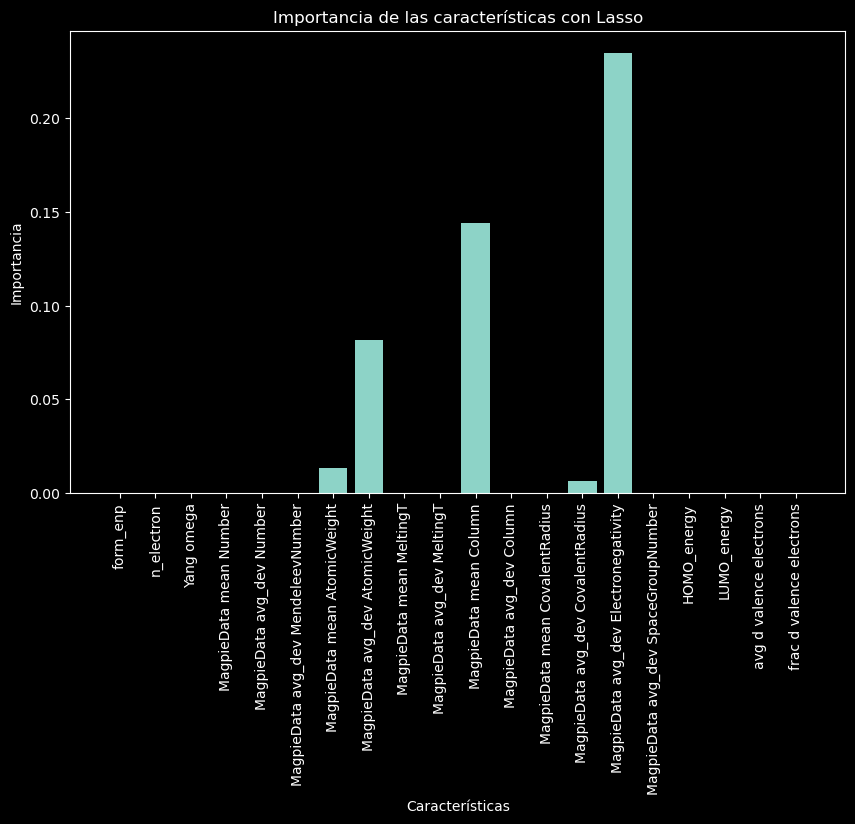

In [194]:
# Extracción de características
# Obtener los coeficientes de Lasso
lasso_coef = lasso.coef_

# Visualizar la importancia de las características
nombres = df.drop('gap opt', axis=1).columns
plt.figure(figsize=(10, 6))
plt.bar(nombres, lasso_coef)
plt.ylabel('Importancia')
plt.xlabel('Características')
plt.xticks(rotation=90)
plt.title('Importancia de las características con Lasso')
plt.savefig('lasso_features.png', dpi=300, format='png', bbox_inches='tight')

plt.show()


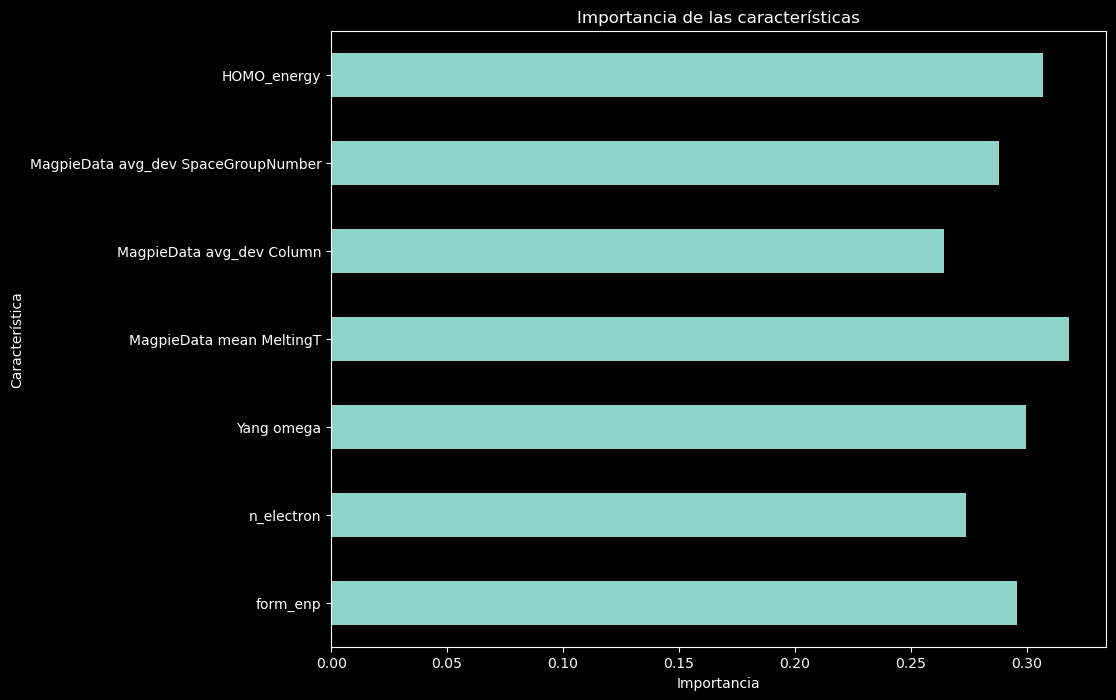

In [337]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# Calcular la importancia de las características
X_new = mutual_info_regression(x, y)



# Crear una Serie con las importancias de las características
feat_imp = pd.Series(X_new, x.columns[0:len(x.columns)])

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura si es necesario
feat_imp.plot(kind='barh')

# Ajustar el tamaño de la fuente de las etiquetas
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Añadir título y etiquetas
plt.title('Importancia de las características')
plt.xlabel('Importancia')
plt.ylabel('Característica')

# Guardar la figura y mostrar el gráfico
plt.savefig('mutual_info_fex.png', dpi=300, format='png', bbox_inches='tight')
plt.show()
